In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
# To install scikit learn 1.1.1
!pip install scikit-learn==1.1.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.4/30.4 MB 22.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.13.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.1 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
sns.set_theme()

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Imports

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)

import pandas as pd
import util.common as util
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.metrics import auc, roc_curve, accuracy_score, balanced_accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import pathlib
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from util.AUROCEarlyStoppingPruneCallback import AUROCEarlyStoppingPruneCallback

# Load Data
Download data into local folder https://gitlab.ilabt.imec.be/mverkerk/ids-dataset-cleaning

In [ ]:
train = {
    "ocsvm": {}, # 10k samples
    "ae": {}, # 100k samples
    "stage2": {}
}
val = {
    "ocsvm": {},
    "ae": {},
    "stage2": {}
}
test = {
    # "y"
    # "y_binary"
    # "y_unknown"
    # "x"
}

## Load Data Stage 1

In [ ]:
clean_dir = "data/"


train["ocsvm"]["x"], train["ocsvm"]["y"], x_benign_val, y_benign_val, _, _, x_malicious_train, y_malicious_train, _, _, _, _, _ = util.load_data(clean_dir, sample_size=1948, train_size=10000, val_size=129485, test_size=56468)

val["ocsvm"]["x"] = np.concatenate((x_benign_val, x_malicious_train))
val["ocsvm"]["y"] = np.concatenate((y_benign_val, np.full(y_malicious_train.shape[0], -1)))


train["ae"]["x"], train["ae"]["y"], x_benign_val, y_benign_val, _, _, x_malicious_train, y_malicious_train, _, _, _, _, _ = util.load_data(clean_dir, sample_size=1948, val_size=129485, test_size=56468)

val["ae"]["x"] = np.concatenate((x_benign_val, x_malicious_train))
val["ae"]["y"] = np.concatenate((y_benign_val, np.full(y_malicious_train.shape[0], -1)))

                                         #Original  #Sampled  #Train  \
Class        Impl                                                      
Benign       Benign                        2071822    195953   10000   
(D)DOS       DDoS                           128014       775       0   
             DoS GoldenEye                   10286        63       0   
             DoS Hulk                       172726      1046       0   
             DoS Slowhttptest                 5228        31       0   
             DoS slowloris                    5383        33       0   
             ALL                            321637      1948       0   
Botnet       Bot                              1948      1948       0   
             ALL                              1948      1948       0   
Brute Force  FTP-Patator                      5931      1263       0   
             SSH-Patator                      3219       685       0   
             ALL                              9150      1948    

## Load Data Stage 2

In [ ]:
n_benign_val = 1500

x_benign_train, _, _, _, x_benign_test, y_benign_test, x_malicious_train, y_malicious_train, x_malicious_test, y_malicious_test, attack_type_train, _, _ = util.load_data(clean_dir, sample_size=1948, train_size=n_benign_val, val_size=6815, test_size=56468)
train["stage2"]["x"], x_val, train["stage2"]["y"], y_val = train_test_split(x_malicious_train, y_malicious_train, stratify=attack_type_train, test_size=1500, random_state=42, shuffle=True)

test['x'] = np.concatenate((x_benign_test, x_malicious_test))
test["y_n"] = np.concatenate((y_benign_test, np.full(y_malicious_test.shape[0], -1)))

val["stage2"]["x"] = np.concatenate((x_val, x_benign_train))
val["stage2"]["y"] = np.concatenate((y_val, np.full(n_benign_val, "Unknown")))

train["stage2"]["y_n"] = pd.get_dummies(train["stage2"]["y"])
val["stage2"]["y_n"] = pd.get_dummies(val["stage2"]["y"])

test["y"] = np.concatenate((np.full(56468, "Benign"), y_malicious_test))
test["y_unknown"] = np.where((test["y"] == "Heartbleed") | (test["y"] == "Infiltration"), "Unknown", test["y"])
test["y_unknown_all"] = np.where(test['y_unknown'] == 'Benign', "Unknown", test['y_unknown'])

                                         #Original  #Sampled  #Train  \
Class        Impl                                                      
Benign       Benign                        2071822     64783    1500   
(D)DOS       DDoS                           128014       775       0   
             DoS GoldenEye                   10286        63       0   
             DoS Hulk                       172726      1046       0   
             DoS Slowhttptest                 5228        31       0   
             DoS slowloris                    5383        33       0   
             ALL                            321637      1948       0   
Botnet       Bot                              1948      1948       0   
             ALL                              1948      1948       0   
Brute Force  FTP-Patator                      5931      1263       0   
             SSH-Patator                      3219       685       0   
             ALL                              9150      1948    

## Scale the data

In [ ]:
scaler = QuantileTransformer(output_distribution='normal')
train['ocsvm']['x_s'] = scaler.fit_transform(train['ocsvm']['x'])
val['ocsvm']['x_s'] = scaler.transform(val['ocsvm']['x'])
test['ocsvm_s'] = scaler.transform(test['x'])

scaler = QuantileTransformer(output_distribution='normal')
train['ae']['x_s'] = scaler.fit_transform(train['ae']['x'])
val['ae']['x_s'] = scaler.transform(val['ae']['x'])
test['ae_s'] = scaler.transform(test['x'])

# scaler = QuantileTransformer(output_distribution='normal')
# train['stage2']['x_s'] = scaler.fit_transform(train['stage2']['x'])
# val['stage2']['x_s'] = scaler.transform(val['stage2']['x'])
# test['stage2_s'] = scaler.transform(test['x'])

# scaler = QuantileTransformer(output_distribution='uniform')
# train['stage2']['x_q'] = scaler.fit_transform(train['stage2']['x'])
# val['stage2']['x_q'] = scaler.transform(val['stage2']['x'])
# test['stage2_q'] = scaler.transform(test['x'])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [ ]:
train['ocsvm']['x_s']

array([[-0.55985906,  0.72416022,  0.83733836, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [ 5.19933758, -0.13031335, -0.13844354, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-0.55985906,  1.41292994,  1.1257762 , ...,  1.28699501,
         1.14553425,  1.40357846],
       ...,
       [-0.55985906, -0.89577982, -0.13844354, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-0.55985906, -2.40855037, -5.19933758, ..., -5.19933758,
        -5.19933758, -5.19933758],
       [-0.55985906, -0.49673537, -0.13844354, ..., -5.19933758,
        -5.19933758, -5.19933758]])

# Detecção de Anomalias com Isolation Forest (Estágio 1)

In [ ]:
from sklearn.ensemble import IsolationForest

N_ESTIMATORS = 98

scaler = QuantileTransformer(output_distribution='normal')

iforest = IsolationForest(n_estimators = N_ESTIMATORS, random_state=RANDOM_SEED)

pca = PCA(n_components=56, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=42)

# Criando um pipeline
model_iforest = Pipeline([
    ('scale_transformer', scaler),
    ('pca', pca),                     # Aplica PCA
    ('iso_forest', iforest)     # Aplica Isolation Forest
])

# Treinando o pipeline
model_iforest.fit(train['ocsvm']['x'])

Pipeline(steps=[('scale_transformer',
                 QuantileTransformer(output_distribution='normal')),
                ('pca', PCA(n_components=56, random_state=42)),
                ('iso_forest',
                 IsolationForest(n_estimators=98, random_state=42))])

## Definindo um threshold e avaliando resultados

In [ ]:
def plot_roc_curve(y_true, y_score, max_fpr=1.0):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  aucroc = roc_auc_score(y_true, y_score)
  plt.plot(100*fpr[fpr < max_fpr], 100*tpr[fpr < max_fpr], label=f'ROC Curve (AUC = {aucroc:.4f})')
  plt.xlim(-2,102)
  plt.xlabel('FPR (%)')
  plt.ylabel('TPR (%)')
  plt.legend()
  plt.title('ROC Curve and AUCROC')

In [ ]:
def get_tpr_per_attack(y_labels, y_pred):
  aux_df = pd.DataFrame({'Label':y_labels,'prediction':y_pred})
  total_per_label = aux_df['Label'].value_counts().to_dict()
  correct_predictions_per_label = aux_df.query('Label != "BENIGN" and prediction == True').groupby('Label').size().to_dict()
  tpr_per_attack = {}
  for attack_label, total in total_per_label.items():
    if attack_label == 'BENIGN':
      continue
    tp = correct_predictions_per_label[attack_label] if attack_label in correct_predictions_per_label else 0
    tpr = tp/total
    tpr_per_attack[attack_label] = tpr
  return tpr_per_attack

In [ ]:
def get_overall_metrics(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  acc = (tp+tn)/(tp+tn+fp+fn)
  tpr = tp/(tp+fn)
  fpr = fp/(fp+tn)
  precision = tp/(tp+fp)
  f1 = (2*tpr*precision)/(tpr+precision)
  return {'acc':acc,'tpr':tpr,'fpr':fpr,'precision':precision,'f1-score':f1}

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  group_counts = [f'{value:.0f}' for value in confusion_matrix(y_true, y_pred).ravel()]
  group_percentages = [f'{value*100:.2f}%' for value in confusion_matrix(y_true, y_pred).ravel()/np.sum(cm)]
  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_counts, group_percentages)]
  labels = np.array(labels).reshape(2,2)
  sns.heatmap(cm, annot=labels, cmap='Oranges', xticklabels=['Predicted Benign', 'Predicted Malicious'], yticklabels=['Actual Benign', 'Actual Malicious'], fmt='')
  return

## Conjunto de validação

In [ ]:
# %%timeit -n3 -r3
# score_val = -model_iforest.decision_function(val['ocsvm']['x_s'])

In [ ]:
score_val = -model_iforest.decision_function(val['ocsvm']['x'])
curves_metrics, summary_metrics = util.evaluate_proba(val['ocsvm']['y'], score_val)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/content/util/common.py:148: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/content/util/common.py:148: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/content/util/common.py:148: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/content/util/common.py:148: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/content/util/common.py:148: RuntimeWarning: invalid value encountered in divide
  results[f"F{i}"] = (1+i**2)*precision*recall/(i**2*precision+recall)
/content/util/common.py:148: RuntimeWarning: invalid value

In [ ]:
summary_metrics

,metric,value,threshold,precision,recall,FPR
0,F1,0.2301,-0.023618,0.1779,0.3257,0.079252
1,F2,0.3531,-0.096991,0.1137,0.7452,0.305896
2,F3,0.4812,-0.098074,0.1125,0.7567,0.314484
3,F4,0.593,-0.122349,0.0896,0.9139,0.489138
4,F5,0.6755,-0.138989,0.0769,0.9812,0.620674
5,F6,0.7445,-0.138989,0.0769,0.9812,0.620674
6,F7,0.7943,-0.138989,0.0769,0.9812,0.620674
7,F8,0.8309,-0.139984,0.0761,0.9833,0.628876
8,F9,0.8586,-0.140556,0.0757,0.9843,0.633108


In [ ]:
quantiles = [0.995, 0.99, 0.975, 0.95]
print({(metric, fpr): t for metric, fpr, t in zip(summary_metrics.metric, summary_metrics.FPR, summary_metrics.threshold)})
print({q: np.quantile(score_val[val["ocsvm"]["y"] == 1], q) for q in quantiles})

{('F1', 0.07925242306058616): -0.023618245679864924, ('F2', 0.30589643588060395): -0.09699079027765112, ('F3', 0.314484303201143): -0.09807409623154756, ('F4', 0.4891377379619261): -0.12234949905528958, ('F5', 0.6206742093678804): -0.13898909514815372, ('F6', 0.6206742093678804): -0.13898909514815372, ('F7', 0.6206742093678804): -0.13898909514815372, ('F8', 0.6288759315750859): -0.13998380259185028, ('F9', 0.633108082017222): -0.14055558057940298}
{0.995: 0.09091109171053309, 0.99: 0.06766017781741557, 0.975: 0.03358335958452108, 0.95: 0.005137046051861486}


In [ ]:
IFOREST_VALIDATION_THRESHOLD = -0.122349 #Recall > 90% AND FPR < 60%

In [ ]:
val['ocsvm']['y']

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [ ]:
score_val

array([-0.13590953, -0.13882599, -0.15640259, ..., -0.00555196,
       -0.02142582,  0.06573475])

In [ ]:
y_val = pd.Series(val['ocsvm']['y'])
y_val = y_val.apply(lambda c: 0 if c == 1 else 1)

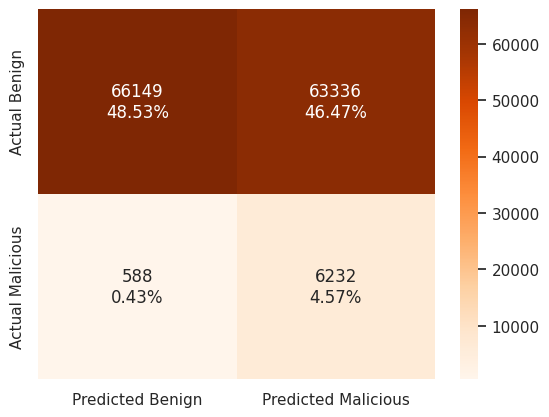

In [ ]:
plot_confusion_matrix(y_val, score_val > IFOREST_VALIDATION_THRESHOLD)

In [ ]:
get_overall_metrics(y_val, score_val > IFOREST_VALIDATION_THRESHOLD)

{'acc': 0.5310223396060306,
 'tpr': 0.9137829912023461,
 'fpr': 0.4891377379619261,
 'precision': 0.08958141674333027,
 'f1-score': 0.16316698957951511}

In [ ]:
y_true = y_val.apply(lambda c: 'Benign' if c == 0 else 'Attack')
y_pred = pd.Series(score_val > IFOREST_VALIDATION_THRESHOLD).apply(lambda c: 'Benign' if c == 0 else 'Attack')

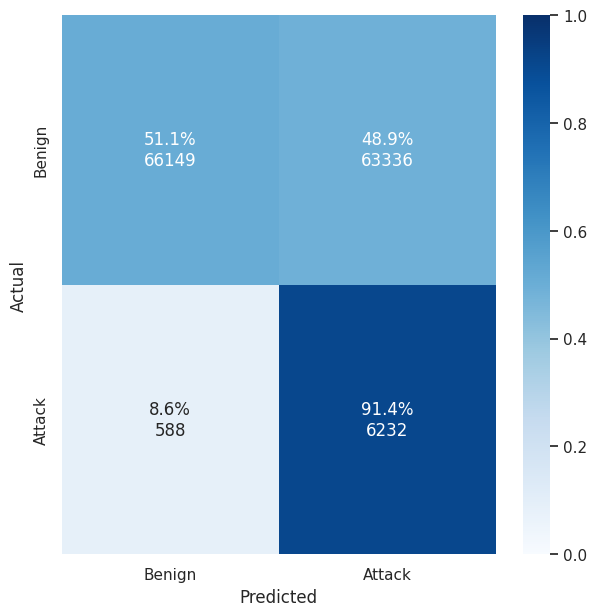

In [ ]:
classes = ['Benign', 'Attack']
util.plot_confusion_matrix(y_true, y_pred, values=classes, labels=classes)

##Carregando o Modelo

In [ ]:
f = open("stage1_IsolationForest_ST.p","rb")
model_iforest = pickle.load(f)

##Salvando o Modelo

In [ ]:
with open('stage1_IsolationForest_ST.p', 'wb') as file:
    pickle.dump(model_iforest, file)

##Pré-Estágio 2

In [ ]:
tau_b = IFOREST_VALIDATION_THRESHOLD #-0.034357

In [ ]:
proba_1 = score_val # invert sign to act as anomaly score
pred_1 = np.where(proba_1 > tau_b, "Attack", "Benign").astype(object)
np.unique(pred_1, return_counts=True)

(array(['Attack', 'Benign'], dtype=object), array([69568, 66737]))

# Detecção de Anomalias com Random Forest (importado) (Estágio 2)

##Carregando o Modelo Random Forest

In [ ]:
tau_m = 0.98 #imported model (article)

In [ ]:
f = open("models/stage2_rf.p","rb")
stage2 = pickle.load(f)
f.close()

In [ ]:
proba_2 = stage2.predict_proba(val['ocsvm']['x'][pred_1 == "Attack"])
pred_2 = np.where(
    np.max(proba_2, axis=1) > tau_m,
    stage2.classes_[np.argmax(proba_2, axis=1)],
    "Unknown")
np.unique(pred_2, return_counts=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
        'Web Attack'], dtype=object),
 array([ 1342,  1301,  1323,  1390, 62935,  1277]))

#Extensão (Estágio 3)

In [ ]:
tau_u = 0.06766017781741557 #quantile 0.99

In [ ]:
proba_3 = proba_1[pred_1 == "Attack"][pred_2 == "Unknown"]
pred_3 = np.where(proba_3 < tau_u, "Benign", "Unknown")
np.unique(pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([61655,  1280]))

#Combinação dos Estágios

In [ ]:
y_pred = pred_1.copy()
y_pred[y_pred == "Attack"] = pred_2
y_pred[y_pred == "Unknown"] = pred_3
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  1342, 128392,   1301,   1323,   1390,   1280,   1277]))

#Teste - Detecção de Anomalias com Isolation Forest + RF (Importado) + Extensão

In [ ]:
test = pd.read_parquet("data/test.parquet")
# test = pd.read_csv("data/test.csv")

y = test["Y"].replace(["Heartbleed", "Infiltration"], "Unknown")
x = test.drop(columns=['Y'])

y.value_counts()

Y
Benign         56468
(D)DOS           584
Port Scan        584
Botnet           584
Brute Force      584
Web Attack       584
Unknown           47
Name: count, dtype: int64

In [ ]:
proba_1 = -model_iforest.decision_function(x) # invert sign to act as anomaly score
pred_1 = np.where(proba_1 > tau_b, "Attack", "Benign").astype(object)
np.unique(pred_1, return_counts=True)

(array(['Attack', 'Benign'], dtype=object), array([30289, 29146]))

In [ ]:
proba_2 = stage2.predict_proba(x[pred_1 == "Attack"])
pred_2 = np.where(
    np.max(proba_2, axis=1) > tau_m,
    stage2.classes_[np.argmax(proba_2, axis=1)],
    "Unknown")
np.unique(pred_2, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
        'Web Attack'], dtype=object),
 array([  568,   553,   570,   594, 27463,   541]))

In [ ]:
proba_3 = proba_1[pred_1 == "Attack"][pred_2 == "Unknown"]
pred_3 = np.where(proba_3 < tau_u, "Benign", "Unknown")
np.unique(pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([26949,   514]))

In [ ]:
y_pred = pred_1.copy()
y_pred[y_pred == "Attack"] = pred_2
y_pred[y_pred == "Unknown"] = pred_3
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  568, 56095,   553,   570,   594,   514,   541]))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, figsize=(7,7), cmap="Blues", values=[-1, 1], labels=["Attack", "Benign"], title="", ax=None, metrics=False):
    cm = confusion_matrix(y_true, y_pred, labels=values)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float)
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            annot[i, j] = '%.1f%%\n%d' % (p * 100, c)
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, cmap=cmap, annot=annot, fmt='', ax=ax, vmin=0, vmax=1)
    if title != "":
        ax.set_title(title)

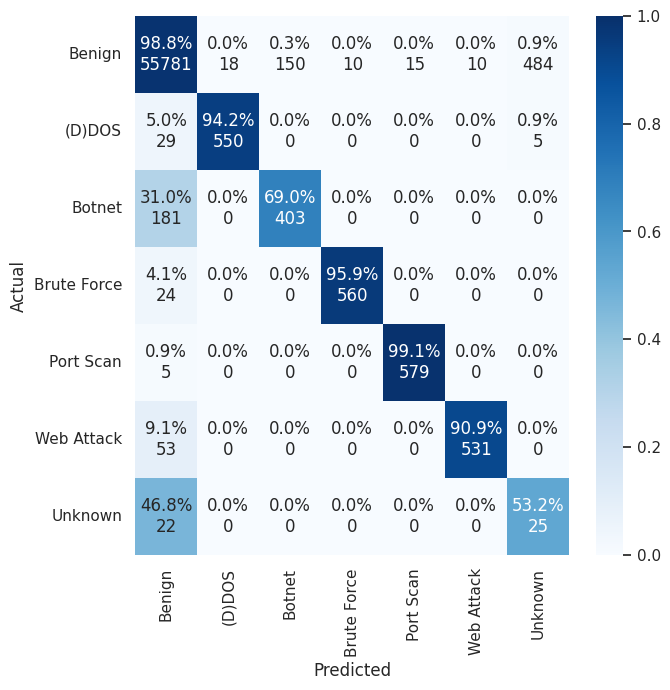

In [ ]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
plot_confusion_matrix(y, y_pred, values=classes, labels=classes, metrics=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, digits=4))

              precision    recall  f1-score   support

      (D)DOS     0.9683    0.9418    0.9549       584
      Benign     0.9944    0.9878    0.9911     56468
      Botnet     0.7288    0.6901    0.7089       584
 Brute Force     0.9825    0.9589    0.9705       584
   Port Scan     0.9747    0.9914    0.9830       584
     Unknown     0.0486    0.5319    0.0891        47
  Web Attack     0.9815    0.9092    0.9440       584

    accuracy                         0.9831     59435
   macro avg     0.8113    0.8587    0.8059     59435
weighted avg     0.9904    0.9831    0.9865     59435

